# Compolsory Assignment 4: Variational Autoencoders
Please fill out the the group name, number, members and optionally the name below.

**Group number**: 31 \
**Group member 1**: Asim Rasheed \
**Group member 2**: Jony Karmakar\
**Group member 2**: Haris Hameed Mian\
**Group name (optional)**: Group31

# Assignment Submission
To complete this assignment answer the relevant questions in this notebook and write the code required to implement the relevant models. The assignemnt is submitted by handing in this notebook as an .ipynb file and as a .pdf file.

We will explore how to use autoencoder netorks using the datsets **CelebA**. This dataset consist of over 200k selfies of famours people. They are also annotated with an list of binary attributes, such as hair, smilling, eye brows, big nose, attractive, etc.

**Part one** is an introduction to encoder-decoder architecture. Here we will use an singel linear transformation to encode the data in an latent representation, and a singel linear transformation to project it back into the visual space.
1. Build an autoencoder using a single dense layer for the encoder/decoder. Use an approperiate latent dimesion as bottelneck. Train it using only reconstruction loss. Save the reconstructed output-image during at least five epoch and visually show how it changes during traing.
2. Build a deeper autoencoder structure with dense layers and none-linearity. The network should be at least three layer deep. Use only reconstructed loss. Train the network using three different dimension of the latent space and show the effect the latent dimension/bottelneck have on the reconstructed image.

**Part two** is an advancement to variational autoencoders. Here we will introduce the regularisation term using KL-divergence and use the power of convelutional networks (CNN) to encode and decode the spatial information in the images.
1. Build a deep encoder and decoder using CNN. You are free to choose the design.
2. Add an sampeling layer at the end of the decoder, enforcing a normal, prior distribution on the latent space. This will be used to draw new samples from the latent space.
3. Use the newtork to generate sample images. Compare them to the orignal.
4. Use the attribute annotation included in the dataset to select one desired feature and generate novel samples with- and without the desired attribute.
5. Interpolate the latent space.

**Bonuse** for fun; upload your own selfi and try to manipulate the latent space to see how you would look with/without selected features!

# Introduction
**Autoencoders** are neural network architectures used for unsupervised learning tasks. They are designed to learn efficient representations of input data by compressing it into a lower-dimensional latent space and then reconstructing it back to its original form. Autoencoders consist of two main components: an encoder and a decoder.
 - The encoder takes in the input data and maps it to a lower-dimensional latent representation. It typically consists of multiple layers that gradually reduce the dimensionality of the input data, capturing its essential features. The output of the encoder is a compressed representation of the input, often referred to as a code or latent vector.
 - The decoder, on the other hand, takes the code from the encoder and reconstructs the original data from it. It mirrors the architecture of the encoder by gradually expanding the code back to the original dimensionality. The output of the decoder is a reconstruction of the input data, which ideally should closely resemble the original input.

**Variational Autoencoders** are a more powerful class of generative models. They combine elements from both autoencoders and probabilistic models to learn an efficient representation of high-dimensional data. VAEs are designed to capture the underlying latent variables that drive the generation of the observed data, enabling them to generate new samples from the learned distribution. Unlike traditional autoencoders, VAEs introduce a **probabilistic component** that allows them to model the data distribution more effectively.

Autoencoders have various applications, including dimensionality reduction, data denoising, and anomaly detection. They can learn useful representations from unlabeled data, which can then be used for downstream tasks like classification or clustering. In this assignemnt we will be exploring the **generative capabilities** of autoencoders and VAE's. By exploring the latent space, we can generate novel samples, allowing for creative applications such as image synthesis or style transfer.

In [ ]:
# IMPORT LIBRARIES
import tensorflow.keras as keras
import pandas as pd
import tensorflow as tf
import numpy as np
import PIL
import PIL.Image
from PIL import Image
import sklearn
import scipy
import pathlib
import time
import os
import matplotlib.pyplot as plt
import zipfile
import shutil

In [ ]:
#Ensure that you have access to Colab's GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
device_name = tf.test.gpu_device_name()

Num GPUs Available:  1


# Part 0: Get the data

The dataset is quite large (>200 k high res. images), however it can be accessed through TensorFlow Datasets. Please note that there is a limit on how many request you can ask within 24h. If you get HTTP error 429 it means you have exceeded that limit. Please concider this when working on the task - aka do as much as posible each session (also try to avoid restarting the kernel).

(The data can also be downloaded directly from the authers [here](https://drive.google.com/drive/folders/1E34_MII_Gw4cAy0lS6BfN62a7ut9Af_2?usp=share_link) )

In [ ]:
import tensorflow_datasets as tfds
celeba_bldr = tfds.builder('celeb_a')
celeba_bldr.download_and_prepare()
celeba = celeba_bldr.as_dataset(shuffle_files=False)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

DownloadError: ignored

*If you havig trouble downloading the data (ERROR 429) you can extract the .zip file from the link above*
1. *Copy the -zip folders to your drive (see link above)*
2. *Unzip folder (You can chose between unzipping in the noteboke, or your drive)*

```
!unzip -u "/YOUR_DRIVE_PATH/celeba_train.zip" -d "/YOUR_DESTINATION_PATH/train"
```
3. *Extract the dataset (ps. train heter test i undermappene)*


```
celeba_train = tf.dataDataset.load('/YOUR_DESTINATION_PATH/train/content/CelebA_test'
```
4. *Repeat for test*


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#To unzip the contents in the folder
!unzip -u "/content/drive/MyDrive/celeba_train.zip" -d "/content/train"
!unzip -u "/content/drive/MyDrive/celeba_validation.zip" -d "/content/valid"


Archive:  /content/drive/MyDrive/celeba_train.zip
   creating: /content/train/content/CelebA_test/
  inflating: /content/train/content/CelebA_test/dataset_spec.pb  
  inflating: /content/train/content/CelebA_test/snapshot.metadata  
   creating: /content/train/content/CelebA_test/4748077372869299807/
   creating: /content/train/content/CelebA_test/4748077372869299807/00000000.shard/
  inflating: /content/train/content/CelebA_test/4748077372869299807/00000000.shard/00000000.snapshot  
Archive:  /content/drive/MyDrive/celeba_validation.zip
   creating: /content/valid/content/CelebA_validation/
   creating: /content/valid/content/CelebA_validation/13188610466669287276/
   creating: /content/valid/content/CelebA_validation/13188610466669287276/00000000.shard/
  inflating: /content/valid/content/CelebA_validation/13188610466669287276/00000000.shard/00000000.snapshot  
  inflating: /content/valid/content/CelebA_validation/dataset_spec.pb  
  inflating: /content/valid/content/CelebA_validatio

In [ ]:
#Load the dataset
celeba_train = tf.data.Dataset.load('/content/train/content/CelebA_test')
celeba_test = tf.data.Dataset.load('/content/valid/content/CelebA_validation')



In [ ]:
# Function to print dataset summary
def dataset_summary(dataset, name):
    print(f"Summary for {name} dataset:")
    num_elements = 0
    for element in dataset:
        num_elements += 1
    print(f"Number of elements: {num_elements}")

# Print summaries for train and test datasets
dataset_summary(celeba_train, "CelebA Train")
dataset_summary(celeba_test, "CelebA Test")



Summary for CelebA Train dataset:
Number of elements: 19962
Summary for CelebA Test dataset:
Number of elements: 19867




---



# Part 1: Build an Autoencoder network

<div>
<img src="https://tikz.net/janosh/autoencoder.png" width="400"/>
<div>

## Task 1.1 Define a prerocessing function

- The images are orignial 218x178, however it could be usefull to reduce the size for efficency purposes.
- As always: preprocessing the image increase performance
- As we are only concerd with reconstruction loss (e.g. try to reconstruct the same image) **we do not care about labels**
- For this reason, a test set is not always needed, altough it will be usefull to have a small "test set" available for emperical experiments.


Following is an example on how to design a keras preprocessing function.
```
def preprocess(example, size=(img_h, img_w), mode='train'):
    image = example['image']
    if mode == 'train':
        image_resized = tf.image.resize(image, size=size)
        return image_resized/255.0, image_resized/255.0
```



In [ ]:
BATCH_SIZE = 32
img_w, img_h = 64,64

In [ ]:
def preprocess(example, size=(img_h, img_w), mode='train'):
    image = example['image']

    if mode == 'train':
        image = tf.image.random_flip_left_right(image)

        # Resize the image
        image_resized = tf.image.resize(image, size=size)

        # Normalize the pixe l values to the range [0, 1]
        image_normalized = image_resized / 255.0

        return image_normalized, image_normalized

    if mode == 'test':
        image_resized = tf.image.resize(image, size=size)
        return image_resized/255.0, image_resized/255.0


In [ ]:
# Implement your preprocessing function on the training- and test-set
# i.e. -> map(lambda x: preprocess(**args))
#train_ds = celeba_train.map(lambda x: **args)
#train_ds = train_ds.batch(BATCH_SIZE)

#test_ds = celeba_test.map(lambda x: **args)
#test_ds = test_ds.batch(BATCH_SIZE)

# Apply preprocessing to the training set
train_ds = celeba_train.map(lambda x: preprocess(x, size=(img_h, img_w), mode='train'))
train_ds = train_ds.batch(BATCH_SIZE)

# Apply preprocessing to the test set
test_ds = celeba_test.map(lambda x: preprocess(x, size=(img_h, img_w), mode='test'))
test_ds = test_ds.batch(BATCH_SIZE)

## Task 1.2 Visualize the dataset

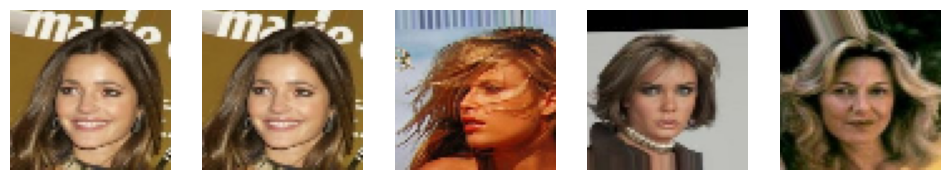

In [ ]:
# Display a few random images
for images, _ in train_ds.take(1):
    # Display a few random images
    num_images_to_display = 5
    rand_indices = tf.random.uniform(shape=(num_images_to_display,), maxval=BATCH_SIZE, dtype=tf.int32)

    plt.figure(figsize=(12, 8))

    for i, idx in enumerate(rand_indices):
        plt.subplot(1, num_images_to_display, i + 1)
        plt.imshow(images[idx].numpy())
        plt.axis('off')

    plt.show()

## Task 1.3 Build a linear encoder and decoder

- The images needs to be flattent before feed into the input layer.
- The output from the decoder needs to be reshaped back into an three-channel image.
- Ensure the output from the decoder are in the valid pixel range (0-1).
- Train the network in at least five epochs

`laten_dim = 64`

1. **Input Layer:**
   - The input layer of the autoencoder takes the raw input data. The size of this layer depends on the dimensionality of the input data. Since we are working with images and dense layers we need to flatten the input space before we can encode it.
   
```
tf.keras.Input(shape=(H,W,C), name='Image input')
tf.keras.layers.Flatten(name='Image_as_vector')
```
2. **Encoder:**
   - The encoder part of the network is responsible for reducing the dimensionality of the input data. It is usually achived by decreasing neuron count.

```
tf.keras.layers.Dense(*args, name='Encode')
```

3. **Latent Space:**
   - The output layer of the encoder is called the latent space. This layer contains the compressed representation of the input
4. **Decoder:**
   - The decoder part of the network aims to reconstruct the original data from the compressed representation in the latent space. It consists layer(s) with an increasing number of neurons

```
tf.keras.layers.Dense(*args, name='Decoder')
#output pixel between 0,1
```
5. **Output Layer:**
   - The output layer of the autoencoder reconstructs the data in a format that matches the input data's dimensionality.

```
tf.keras.layers.Reshape(*args, name='Output')
```


The training process involves minimizing a loss function, typically an **reconstruction loss** which measures the difference between the original input and the reconstructed output. Use Binary cross-entropy loss which emphasizes correct representation of the data. It penalizes the model more when it produces a significantly different value from the ground truth, effectively encouraging the model to capture and reconstruct the important binary features (pixel) accurately.

In [ ]:
# Design your model
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape

# H, W, and C are the height, width, and channels
H, W, C = 64, 64, 3

latent_dim = 64

# Input layer
input_layer = Input(shape=(H, W, C), name='Image_input')

# Flatten the input
flat_input = Flatten(name='Image_as_vector')(input_layer)

# Encoder
encoder = Dense(latent_dim, activation='relu', name='Encode')(flat_input)

# Latent space
latent_space = Dense(latent_dim, activation='relu', name='Latent_space')(encoder)

# Decoder
decoder = Dense(H * W * C, activation='sigmoid', name='Decoder')(latent_space)

# Reshape to the original image dimensions
output_layer = Reshape((H, W, C), name='Output')(decoder)

# Autoencoder model
autoencoder = tf.keras.Model(input_layer, output_layer, name='Autoencoder')



### Task 1.3.1 Train the network and save a reconstructed image at the end of each epoch
- Save chekpoints at end of each training epoch (>5) to visualise the evolution of the reconstructed images during training
- Use ```callbacks=[model_checkpoint_callback]```
 to save weigths at end of each epoche.
- ```optimizer='adam'```
- ```loss='binary_crossentropy'```

```
# Example on how to implement callbacks during training
with tf.device(device_name):
    model.fit(**args, callbacks=[model_checkpoint_callback])
```



In [ ]:
# Use this definition of checkpoints
#model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
   # filepath='./tmp/weights_{epoch:02d}.hdf5',
   # save_weights_only=True,
   # monitor='loss',
   # mode='auto',
    #save_freq = 'epoch',
   # save_best_only=False)

In [ ]:
# Compile and train your model
# Compile the model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# ModelCheckpoint callback
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./tmp/weights_{epoch:02d}.hdf5',
    save_weights_only=True,
    monitor='loss',
    mode='auto',
    save_freq='epoch',  # Save at the end of each epoch
    save_best_only=False)

epochs = 5

# Training the model with callbacks
autoencoder.fit(train_ds, epochs=epochs, callbacks=[model_checkpoint_callback])


Epoch 1/5
624/624 [==============================] - 25s 26ms/step - loss: 0.5639
Epoch 2/5
624/624 [==============================] - 8s 14ms/step - loss: 0.5441
Epoch 3/5
624/624 [==============================] - 11s 17ms/step - loss: 0.5404
Epoch 4/5
624/624 [==============================] - 8s 12ms/step - loss: 0.5357
Epoch 5/5
624/624 [==============================] - 8s 13ms/step - loss: 0.5334


### Task 1.3.2 Visualise the reconstruted images during training

Keras ModelCheckpoint is used to save the models (weights) at some frequency. By loading the weights at the end of each epoch we can visualise the output. See example below for how to implement the saved weights from 'filepath'.

```
random_img = np.random.randint(0, len(test_np))
len_check = len(os.listdir('./tmp/'))
fig, ax = plt.subplots(1, len_check+1, figsize=(15,15))
for i, weights in enumerate(os.listdir('./tmp/')[::-1],1):
    epoch_model = tf.keras.models.clone_model()         # Clone the orignal model structure
    epoch_model.load_weights('./tmp/' + weights)
    epoch_pred = epoch_model.predict(test_np, verbose=0)
    ax[0].imshow(test_np[random_img])
    ax[i].imshow(epoch_pred[random_img])
    ax[i].axis('off')
    ax[0].axis('off')
    if i!=len_check:
        ax[i].set_title('Epoch: {}'.format(i))
    else:
        ax[i].set_title('Output')
    ax[0].set_title('Original')```



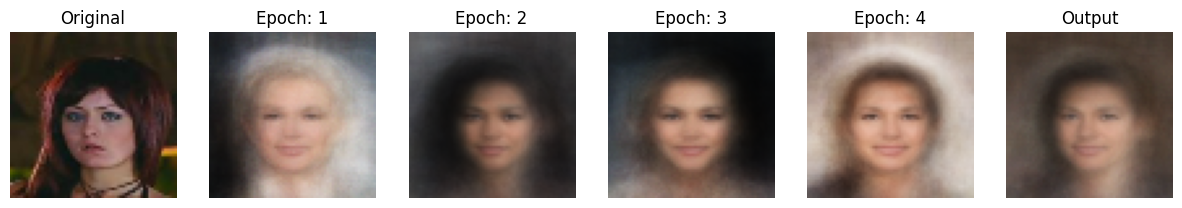

In [ ]:
# Display the reconstructed images at the end of each training epoch
random_img = np.random.randint(0, len(test_ds))
len_check = len(os.listdir('./tmp/'))

test_iterator = iter(test_ds)

fig, ax = plt.subplots(1, len_check + 1, figsize=(15, 15))

for i, weights in enumerate(os.listdir('./tmp/')[::-1],1):
    epoch_model = tf.keras.models.clone_model(autoencoder)
    epoch_model.load_weights(os.path.join('./tmp/', weights))
    test_batch = next(test_iterator)
    test_images = tf.unstack(test_batch)
    random_img = random_img % len(test_images[0])
    epoch_pred = epoch_model.predict(test_images[0], verbose=0)
    ax[0].imshow(test_images[0][random_img].numpy())
    ax[i].imshow(epoch_pred[random_img])
    ax[i].axis('off')
    ax[0].axis('off')
    if i != len_check:
        ax[i].set_title('Epoch: {}'.format(i)) #ax[i].set_title('Epoch: {}'.format(int(weights.split('_')[-1].split('.')[0])))
    else:
        ax[i].set_title('Output')

ax[0].set_title('Original')
plt.show()



### Task 1.3.3. Discuss:
**The image's resemblance to the origninal is quite good after the first epoch, what might be some reasons for this?**


The ReLU activation in the encoder may enable the model to learn sparse representations, focusing on the most relevant features. This sparsity can lead to quicker convergence by emphasizing the most critical aspects of the data.That could be the reason why the image generation after the first epoch is good. Another reason could be the use of sigmoid activation in the decoder. This is particularly suitable for image data, where pixel values are typically normalized between 0 and 1. The sigmoid activation may help the model quickly adapt to the pixel intensity range.

## Task 1.4: Train the network using different latent dimensions.
The purpose of latent dimensions in autoencoders is to represent a compressed and continuous encoding space that might;
 1. captures meaningful features and variations within the data
 2. enabling generation of new, similar samples
 3. aiding in tasks like denoising and anomaly detection.


To visually understand the effect of the lantet space, train your network with three differnet dimensions of the latent space (small < 16, medium < 128, and large > 256) and visualise the reconstructed images.




```
latent_dimensions = []         # Example [8,64,128]
model_list        = []         # Empty list to store weights of each latent- dim model
train_history     = []         # Useful for next task
train_time        = []         # Useful for next task

for i in latent_dimensions:
    # Initiate and compile the model
    print('Training model with latent dimension: %d'%(i))
    
    temp_model = model_def(i)
    temp_mode.compile(**args)
    
    start = time.time()
    with tf.device(device_name):
        history = temp_model.fit(*args)
    end = time.time()

    # Store output    
    model_list.append(temp_model.get_weights())
    train_history.append(history)
    train_time.append(end-start)
```



In [ ]:
import time
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape


def model_def(latent_dim):
    # Input layer
    input_layer = Input(shape=(H, W, C), name='Image_input')

    # Flatten the input
    flat_input = Flatten(name='Image_as_vector')(input_layer)

    # Encoder
    encoder = Dense(latent_dim, activation='relu', name='Encode')(flat_input)

    # Latent space
    latent_space = Dense(latent_dim, activation='relu', name='Latent_space')(encoder)

    # Decoder
    decoder = Dense(H * W * C, activation='sigmoid', name='Decoder')(latent_space)

    # Reshape to the original image dimensions
    output_layer = Reshape((H, W, C), name='Output')(decoder)

    # Autoencoder model
    autoencoder = tf.keras.Model(input_layer, output_layer, name='Autoencoder')

    # Compile the model
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

    return autoencoder

latent_dimensions = [8, 64, 128]  # Example [8, 64, 128]
model_list = []  # Empty list to store weights of each latent-dim model
train_history = []  # Useful for the next task
train_time = []  # Useful for the next task


for i in latent_dimensions:
    # Initiate and compile the model
    print('Training model with latent dimension: %d' % (i))

    temp_model = model_def(i)

    start = time.time()
    history = temp_model.fit(train_ds, epochs=epochs)
    end = time.time()

    # Store output
    model_list.append(temp_model.get_weights())
    train_history.append(history)
    train_time.append(end - start)


Training model with latent dimension: 8
Epoch 1/5
624/624 [==============================] - 10s 13ms/step - loss: 0.5994
Epoch 2/5
624/624 [==============================] - 9s 15ms/step - loss: 0.5787
Epoch 3/5
624/624 [==============================] - 7s 11ms/step - loss: 0.5748
Epoch 4/5
624/624 [==============================] - 10s 16ms/step - loss: 0.5731
Epoch 5/5
624/624 [==============================] - 7s 12ms/step - loss: 0.5718
Training model with latent dimension: 64
Epoch 1/5
624/624 [==============================] - 8s 11ms/step - loss: 0.5643
Epoch 2/5
624/624 [==============================] - 10s 16ms/step - loss: 0.5433
Epoch 3/5
624/624 [==============================] - 9s 14ms/step - loss: 0.5382
Epoch 4/5
624/624 [==============================] - 10s 17ms/step - loss: 0.5349
Epoch 5/5
624/624 [==============================] - 7s 12ms/step - loss: 0.5329
Training model with latent dimension: 128
Epoch 1/5
624/624 [==============================] - 11s 15ms/s

In [ ]:
# TRAIN INDIVIDUAL NETWORKS WITH DIFFERENT LATENT DIMENSIONS



```
random_image = np.random.randint(0,len(test_np))
PSNR_list = []                      # Useful for next task

fig, axs = plt.subplots(1, len(latent_dimensions)+1)
axs[0].imshow(test_np[random_image])
axs[0].set_title('Original')

for i in range(len(latent_dimensions)):
    model =                         # Set the orignal model
    model.set_weights(model_list[i])
    reconstructed_image = model.predict(test_np)

    axs[i+1].imshow(reconstructed_image[random_image])
    axs[i+1].set_title('Latent dim: %d'%(latent_dimensions[i]))
    axs[i].axis('off')
    axs[i+1].axis('off')

    PSNR_list.append(np.mean(tf.image.psnr(x_pred, test_np, max_val=1)))
```



621/621 [==============================] - 13s 20ms/step


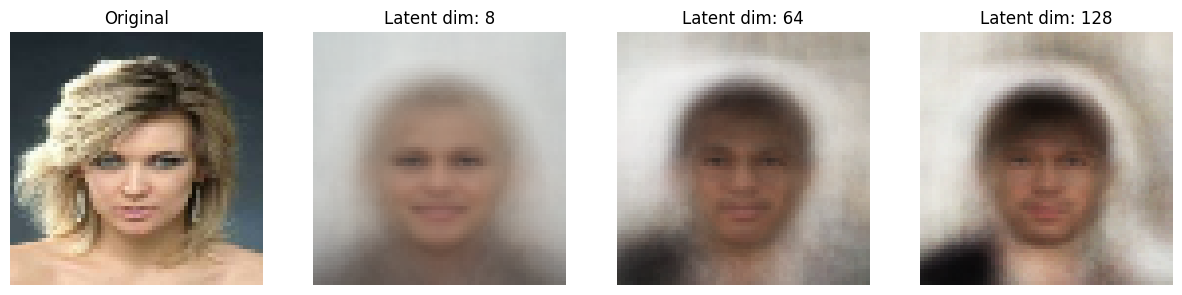

In [ ]:
random_image_index = np.random.randint(0, len(test_ds))

PSNR_list = []  # Useful for the next task

fig, axs = plt.subplots(1, len(latent_dimensions) + 1, figsize=(15, 5))  # Adjust figsize as needed

def extract_image(dataset, index):
    return next(iter(dataset.skip(index).take(1)))[0].numpy()

original_image_batch = extract_image(test_ds, random_image_index)

original_image = original_image_batch[0]

axs[0].imshow(original_image)
axs[0].set_title('Original')

for i in range(len(latent_dimensions)):
    model = model_def(latent_dimensions[i])
    model.set_weights(model_list[i])

    reconstructed_image = model.predict(test_ds)
    reconstructed_image = reconstructed_image[random_image_index]

    axs[i + 1].imshow(reconstructed_image)
    axs[i + 1].set_title('Latent dim: %d' % (latent_dimensions[i]))
    axs[i].axis('off')
    axs[i + 1].axis('off')

    # Calculate PSNR
    psnr_value = tf.image.psnr(np.expand_dims(original_image, axis=0), np.expand_dims(reconstructed_image, axis=0), max_val=1)
    PSNR_list.append(np.mean(psnr_value))

plt.show()




1/1 [==============================] - 0s 113ms/step


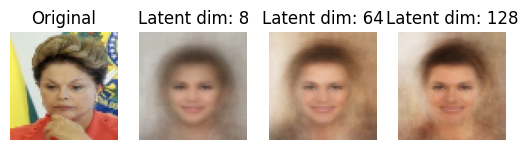

In [ ]:
# VISUALISE THE IMAGES GENERATED FROM DIFFERNET LATENT SIZES
viz_sub = np.stack(list(test_ds.take(1))).squeeze(0)[0]
random_image = np.random.randint(0,len(viz_sub))
PSNR_list = []                      # Useful for next task


fig, axs = plt.subplots(1, len(latent_dimensions)+1)
axs[0].imshow(viz_sub[random_image])
axs[0].set_title('Original')

for i in range(len(latent_dimensions)):
    model = model_def(latent_dimensions[i])  # Set the orignal model
    model.set_weights(model_list[i])
    reconstructed_image = model.predict(viz_sub)

    axs[i+1].imshow(reconstructed_image[random_image])
    axs[i+1].set_title('Latent dim: %d'%(latent_dimensions[i]))
    axs[i].axis('off')
    axs[i+1].axis('off')

    PSNR_list.append(np.mean(tf.image.psnr(reconstructed_image, viz_sub, max_val=1)))

## Task 1.3.3: What effect does the latent space have on the reconstructed image?

- Here we will compare loss, PSNR value, and training time

PSNR stands for Peak Signal-to-Noise Ratio, and it is a metric commonly used to evaluate the quality of image compression. It measures the ratio between the maximum possible power of a signal (in this case, an image) and the power of the noise introduced by the compression process. Higher values are better.



```
X_axis = np.arange(len(latent_dimensions))
psnr = PSNR_list
train_loss = [train_history[i].history['loss'][0] for i in range(len(train_history))]
```



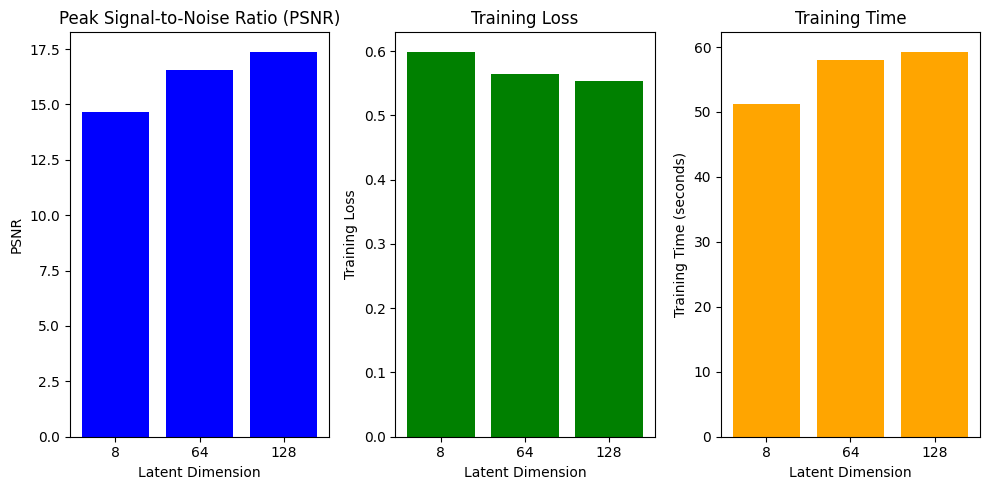

In [ ]:
# Plot
X_axis = np.arange(len(latent_dimensions))
psnr = PSNR_list
train_loss = [train_history[i].history['loss'][0] for i in range(len(train_history))]
train_time = train_time

# PSNR
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.bar(X_axis, psnr, tick_label=latent_dimensions, color='blue')
plt.xlabel('Latent Dimension')
plt.ylabel('PSNR')
plt.title('Peak Signal-to-Noise Ratio (PSNR)')

# Training Loss
plt.subplot(1, 3, 2)
plt.bar(X_axis, train_loss, tick_label=latent_dimensions, color='green')
plt.xlabel('Latent Dimension')
plt.ylabel('Training Loss')
plt.title('Training Loss')

# Training Time
plt.subplot(1, 3, 3)
plt.bar(X_axis, train_time, tick_label=latent_dimensions, color='orange')
plt.xlabel('Latent Dimension')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time')

plt.tight_layout()
plt.show()


## Task 1.3.4: Discuss:
1. **What is a latent representation in the context of machine learning, and how does it differ from the original data representation?**
2. **In unsupervised learning, why do researchers and practitioners often prefer to work with latent representations instead of raw data?**
3. **What challenges and potential drawbacks are associated with using latent representations in machine learning?**
4. **Discuss the trade-offs between using a higher-dimensional latent space and a lower-dimensional one in various applications?**

**Answer 1:** A letent representation refers to a compressed, abstract, or hidden representation of the input data that captures meaningful features or patterns.

**Answer 2:** It is preffered to work with latent representation instead of raw data due to dimensionality reduction, noise reduction and generalization (capture underlying structures and patterns in the data).

**Answer 3:** The following are the challenges and drawback of using latent representation

o It may involve some loss of information

o The effectiveness of the representation depends on the quality of the chosen encoding method.

o Latent representations may not have a clear semantic interpretation, making it challenging to understand and interpret the learned features.

o Building models that learn meaningful latent representations can be computationally intensive and may require sophisticated architectures.

**Answer 4:**

o Higher-dimensional latent space can capture more complex and intricate relationships in the data, potentially leading to more expressive models. Where as low-dimensional latent space may struggle to capture complex patterns present in high-dimensional data, potentially leading to information loss.


o Higher-dimensional latent space  has increased computational complexity, higher risk of overfitting, and challenges in interpretability. Where as lower-dimensional latent space reduced risk of overfitting, low computational complexity, and often improved interpretability.




---



# Task 2: Building a Variational Autoencoder (VAE) network

- Variational Autoencoders, in contrast to the deterministic Autoencoders, learn a probabilistic distribution over the latent space. VAEs use regularization techniques, such as the Kullback-Leibler (KL) divergence, to encourage the learned latent space to be continuous and well-structured. The KL divergence term in the VAE loss function penalizes the model if the learned latent space deviates significantly from a prior distribution, usually a simple Gaussian distribution.

<div>
<img src="https://tikz.net/janosh/vae.png" width="400"/>
<div>

## Task 2.1 Create a deep convelutional encoder and deocoder
- Build a deep CNN encoder and an symmetric decoder. Keep track of your dimension. A tip is to make the network dynamical w.r.t. the input dimensions of the image.
- Feel free to alter the architecture of the network as you see fit (belowe is an exampel on how to design your encoder and decoder.)


```
def encoder(input_shape, hidden_dim, laten_dim, model_name):
    """
        Builds the encoder architecture.
        Input_shape: dimension of image [BxHxWxC] - i.e. [256,28,28,3]
        hidden_layers: number and dimension of layers [l1, l2, l3], where layer (i) > layer (i+1) - i.e. [512, 256, 128]
        latnet_dim: dimension of latent space int - i.e. 64
    """
    # INITIATE INPUT STRUCTURE
    input = keras.Input(shape=(input_shape[0],input_shape[0], input_shape[2]), name='Image dimension')
    x = input

    # CONVOLUTIONAL LAYERS
    for l in hidden_dim:
        x = tf.keras.layers.Conv2D(l, 3, activation="relu", strides=2, padding="same", name='Conv_dim%i'%(l))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU()(x)

    # FLATTEN
    x = tf.keras.layers.Flatten(name='Flatten_1d_vector')(x)

    # LATENT SPACE
    x = keras.layers.Dense(laten_dim, name='Latent_space')(x)
    
    # VARIATIONAL LAYER
    z_mu = keras.layers.Dense(laten_dim, name='Z_mean')(x)
    z_var = keras.layers.Dense(laten_dim, name='Z_variation')(x)

    return tf.keras.Model(input,[z_mu, z_var], name=model_name)
```



In [ ]:
import tensorflow as tf
from tensorflow import keras

def encoder(input_shape, hidden_dim, latent_dim, model_name):
    """
    Builds the encoder architecture.
    input_shape: dimension of image [BxHxWxC] - i.e., [64, 64, 3]
    hidden_dim: number and dimension of layers [l1, l2, l3], where layer (i) > layer (i+1) - i.e., [64, 32, 16]
    latent_dim: dimension of latent space int - i.e., 64
    model_name: name of the model
    """
    # INITIATE INPUT STRUCTURE
    input = keras.Input(shape=(input_shape[1:]), name='Image dimension')
    x = input

    # CONVOLUTIONAL LAYERS
    for l in hidden_dim:
        x = keras.layers.Conv2D(l, 3, activation="relu", strides=2, padding="same", name='Conv_dim%i'%(l))(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.LeakyReLU()(x)

    # FLATTEN
    x = keras.layers.Flatten(name='Flatten_1d_vector')(x)

    # LATENT SPACE
    x = keras.layers.Dense(latent_dim, name='Latent_space')(x)

    # VARIATIONAL LAYER
    z_mu = keras.layers.Dense(latent_dim, name='Z_mean')(x)
    z_var = keras.layers.Dense(latent_dim, name='Z_variation')(x)

    return keras.Model(input, [z_mu, z_var], name=model_name)





```
def decoder(output_channel, hidden_dim, laten_dim, model_name):
    """
        Builds the decoder architecture.
        Output_channel: channels of image [C] (int) - i.e. 3
        hidden_layers: number and dimension of layers [l1, l2, l3], where layer (i) > layer (i+1) (should be same
            as encoder for a symmetric network) - i.e. [512, 256, 128]
        latnet_dim: dimension of latent space int - i.e. 64 (must be same as from encoding)
    """
    # INPUT FROM LATENT SAMPLE SPACE
    laten_input = keras.Input(shape=(laten_dim), name='Latent input')

    x = keras.layers.Dense(img_h*img_w*2, activation='relu', name='Latent_dense')(laten_input)
    x = keras.layers.Reshape((int(img_h/8), int(img_w/8), hidden_dim[-1]), name='Convolution_dimension')(x)

    # DE-CONVELUTIONAL LAYERS
    for l in hidden_dim[::-1]:
        x = tf.keras.layers.Conv2DTranspose(l, 3, activation="relu", strides=2, padding="same", name='ConvTransose_dim%i'%(l))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU()(x)

    # OUTPUT: SAME AS ORIGNIAL INPUT DIMENSIONS. Sigmoid for pixel values 0-1
    output = tf.keras.layers.Conv2DTranspose(output_channel, 3, activation="sigmoid", padding="same", name='Conv_Output')(x)

    return tf.keras.Model(laten_input, output, name=model_name)
```



In [ ]:
import tensorflow as tf
from tensorflow import keras

def decoder(output_channel, hidden_dim, latent_dim, model_name):
    """
    Builds the decoder architecture.
    output_channel: channels of image [C] (int) - i.e., 3
    hidden_dim: number and dimension of layers [l1, l2, l3], where layer (i) > layer (i+1) (should be same
        as encoder for a symmetric network) - i.e., [128, 256, 512]
    latent_dim: dimension of latent space int - i.e., 64 (must be the same as from encoding)
    model_name: name of the model
    """
    # INPUT FROM LATENT SAMPLE SPACE
    latent_input = keras.Input(shape=(latent_dim,), name='Latent_input')

    x = keras.layers.Dense(units=int(img_h/8)*int(img_w/8)*hidden_dim[-1], activation='relu', name='Latent_dense')(latent_input)
    x = keras.layers.Reshape((int(img_h/8), int(img_w/8), hidden_dim[-1]), name='Reshape_to_convolution_dim')(x)

    # DE-CONVOLUTIONAL LAYERS
    for l in hidden_dim[::-1]:
        x = keras.layers.Conv2DTranspose(l, 3, activation="relu", strides=2, padding="same", name='ConvTranspose_dim%i'%(l))(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.LeakyReLU()(x)

    # OUTPUT: SAME AS ORIGINAL INPUT DIMENSIONS. Sigmoid for pixel values 0-1
    output = keras.layers.Conv2DTranspose(output_channel, 3, activation="sigmoid", padding="same", name='Conv_Output')(x)

    return keras.Model(latent_input, output, name=model_name)



In [ ]:
# Define you encoder and decoder architecture here. (No need to compile or train them yet!)

## Task 2.2 Create a sampling layer using the reparameterization trick*
- To be able to update the parameters of VAE using backpropagation, we need to consider that the sampling node inside is stochastic in nature. We can compute the gradients of the sampling node with respect to the learned mean and log-variance vector. This is achived by reparameterize our sampling layer.

<div>
<img src="https://i.stack.imgur.com/Djjr1.png" width="400"/>
<div>


In [ ]:
# Definitation of a reprarametrization layer
class reparameterization_layer(tf.keras.layers.Layer):
    """
    Input: Mean Vector, Variance Vector (from the variational layers of the Encoder - see illustration above)
    Output: Z = μ + σ⊙ε     where ε ~ 𝒩(0,1) and σ = exp(z_var/2)
    """
    def call(self,z_inputs):
        z_mean, z_std = z_inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_std) * epsilon, z_mean, z_std

In [ ]:
# Add the sampling layer to the end of your encoder (with the output from the orignal encoder as input) HINT: Use Keras Sequentual model API!
# Define the new model


In [ ]:
import keras
from keras.layers import Input, Conv2D, BatchNormalization, LeakyReLU, Flatten, Dense, Lambda
from keras.models import Model, Sequential
from keras import backend as K

def sampling(args):
    z_mean, z_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_var) * epsilon

def encoder(input_shape, hidden_dim, latent_dim, model_name):
    """
    Builds the encoder architecture.
    input_shape: dimension of image [BxHxWxC] - i.e., [64, 64, 3]
    hidden_dim: number and dimension of layers [l1, l2, l3], where layer (i) > layer (i+1) - i.e., [64, 32, 16]
    latent_dim: dimension of latent space int - i.e., 64
    model_name: name of the model
    """
    # INITIATE INPUT STRUCTURE
    input = keras.Input(shape=(input_shape[1:]), name='Image_dimension')
    x = input

    # CONVOLUTIONAL LAYERS
    for l in hidden_dim:
        x = Conv2D(l, 3, activation="relu", strides=2, padding="same", name='Conv_dim%i'%(l))(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)

    # FLATTEN
    x = Flatten(name='Flatten_1d_vector')(x)

    # LATENT SPACE
    x = Dense(latent_dim, name='Latent_space')(x)

    # VARIATIONAL LAYER
    z_mu = Dense(latent_dim, name='Z_mean')(x)
    z_var = Dense(latent_dim, name='Z_variation')(x)

    # SAMPLING LAYER
    z = Lambda(sampling, output_shape=(latent_dim,), name='Sampling')([z_mu, z_var])

    return Model(input, [z_mu, z_var, z], name=model_name)


# Define your input dimensions and other parameters
input_shape = [256,64,64,3]
hidden_dim = [512, 256, 128]
latent_dim = 64
output_channel = 3
img_h, img_w = 64, 64

# Build the VAE model
vae = encoder(input_shape, hidden_dim, latent_dim, 'my_vae')

# Compile the model and define your loss function
vae.compile(optimizer='adam', loss='mse')  # You can use a different loss function based on your task

# Print the model summary
vae.summary()


Model: "my_vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Image_dimension (InputLaye  [(None, 64, 64, 3)]          0         []                            
 r)                                                                                               
                                                                                                  
 Conv_dim512 (Conv2D)        (None, 32, 32, 512)          14336     ['Image_dimension[0][0]']     
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 512)          2048      ['Conv_dim512[0][0]']         
 Normalization)                                                                                   
                                                                                             

## Task 2.3 Build a custom model including reconstruction loss and KL divergence
- Below we have defined a keras Model that takes **the previously defined encoder and decoder** as input and designe the training process.
- The training process tracks two losses:


> **Reconstruction Loss** = $||x - \bar x ||_2 = ||x - decoder(z) ||_2 = ||x - d(\mu_x + \sigma_x \epsilon)||_2$ where $\mu_x,\sigma_x = encoder(x), \epsilon \sim \mathcal{N}(0,I)$


> **Similarity Loss/KL Divergence** = $D_{KL}(\mathcal{N}(\mu_x, \sigma_x) || \mathcal{N}(0,I))$



In [ ]:
class VAE(tf.keras.Model):
    """
    Input: encoder, decoder
    1. Track reconstruction loss, kl divergence, and total loss
    2. Update gradients
    Output: loss
    """
    def __init__(self, encoder: tf.keras.Model, decoder: tf.keras.Model):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

        self.rec_loss_tracker = keras.metrics.Mean(name="rec_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.tot_loss_tracker = keras.metrics.Mean(name="total_loss")


    def train_step(self, data):
        x,y = data
        with tf.GradientTape() as grad:
            z, z_m, z_s = self.encoder(x)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(y, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_s - tf.square(z_m) - tf.exp(z_s))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss

        grads = grad.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.tot_loss_tracker.update_state(total_loss)
        self.rec_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.tot_loss_tracker.result(),
            "reconstruction_loss": self.rec_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [ ]:
 # Build, compile and train a model
encoder_mod = encoder(input_shape, hidden_dim, latent_dim, 'encoder')
decoder_mod = decoder(output_channel, hidden_dim, latent_dim, 'decoder')
vae = VAE(encoder=encoder_mod, decoder=decoder_mod)
vae.compile(optimizer=keras.optimizers.Adam())

# Eager execution mode
#tf.config.run_functions_eagerly(True)

#with tf.device(device_name):
vae.fit(train_ds, epochs=10)

Epoch 1/10
624/624 [==============================] - 111s 158ms/step - loss: 2390.4248 - reconstruction_loss: 2371.9644 - kl_loss: 17.4945
Epoch 2/10
624/624 [==============================] - 101s 161ms/step - loss: 2125.5027 - reconstruction_loss: 2108.6741 - kl_loss: 16.8155
Epoch 3/10
624/624 [==============================] - 100s 161ms/step - loss: 2091.7759 - reconstruction_loss: 2074.9970 - kl_loss: 16.8038
Epoch 4/10
624/624 [==============================] - 100s 161ms/step - loss: 2077.2567 - reconstruction_loss: 2060.5700 - kl_loss: 16.7269
Epoch 5/10
624/624 [==============================] - 101s 162ms/step - loss: 2069.3524 - reconstruction_loss: 2052.6889 - kl_loss: 16.6332
Epoch 6/10
624/624 [==============================] - 101s 163ms/step - loss: 2064.6689 - reconstruction_loss: 2048.1297 - kl_loss: 16.5601
Epoch 7/10
624/624 [==============================] - 100s 161ms/step - loss: 2062.8771 - reconstruction_loss: 2046.2062 - kl_loss: 16.6539
Epoch 8/10
624/624 [

## Task 2.4: Discussion

1. **How does the reparameterization trick enable VAEs to generate diverse and realistic samples in the latent space?**
2. **In the absence of the reparameterization trick, how would training VAEs differ, and what impact would it have on the overall model performance?**

**Answer 1:** The reparameterization trick in VAEs replaces direct sampling from a distribution with a differentiable process involving a fixed distribution. This enables gradient-based optimization during training. By allowing smooth interpolation in the latent space, diverse and realistic samples can be generated during the decoding process.

**Answer 2:** Without the reparameterization trick, direct sampling from the latent space during training would introduce non-differentiability, making it challenging to backpropagate gradients through the stochastic operation. This would hinder the use of standard gradient-based optimization algorithms, impacting the overall training process and potentially leading to slower convergence and less effective learning of a meaningful latent space representation.



---



# Task 3: Generate data
- Due to the probabilistic nature of VAEs, they can generate new data points by sampling from the learned latent space. By sampling from the latent distribution, the VAE can produce new data points that are similar to the training data but not identical to any specific input in the dataset.


## Task 3.1 Reconstruct sample by sampling the latent space
- Encode and decode a set of images



```
data_subset = np.stack(list(test_ds.take(1))).squeeze(0)[0]
reconstructed_image = Decode(Encode(data_subset)[0])
```



In [ ]:
data_subset = np.stack(list(test_ds.take(1))).squeeze(0)[0]  # Take a batch of images from the test dataset
encoded_latent_space = vae.encoder(data_subset)[0]
reconstructed_image = vae.decoder(encoded_latent_space)

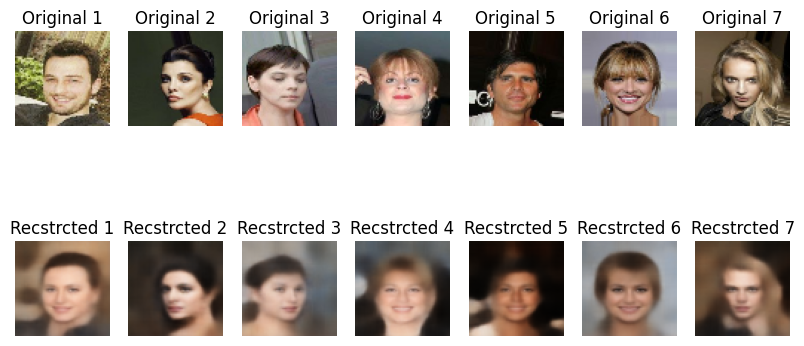

In [ ]:
def reconstruct_images(model, images):
    z, z_mean, z_log_var = model.encoder(images)

    reconstructed_images = model.decoder(z)

    return reconstructed_images

data_subset = np.stack(list(test_ds.take(1))).squeeze(0)[0][:7]

data_subset = np.reshape(data_subset, (data_subset.shape[0], data_subset.shape[1], data_subset.shape[2], 3))

data_subset = tf.convert_to_tensor(data_subset, dtype=tf.float32)

# data_subset = data_subset / 255.0  # Uncomment this line if pixel values are in the range [0, 255]

reconstructed_images = reconstruct_images(vae, data_subset)

plt.figure(figsize=(10, 5))

# Original images
for i in range(data_subset.shape[0]):
    plt.subplot(2, data_subset.shape[0], i + 1)
    plt.imshow(data_subset[i])
    plt.axis('off')
    plt.title(f'Original {i + 1}')

# Reconstructed images
for i in range(reconstructed_images.shape[0]):
    plt.subplot(2, reconstructed_images.shape[0], i + 1 + data_subset.shape[0])
    plt.imshow(reconstructed_images[i])
    plt.axis('off')
    plt.title(f'Recstrcted {i + 1}')

plt.show()

## Task 3.2 Generate new sample from a normal (Gaussian) distribution
- Decode an image from a random sample distribution (of same dimensions!)



```
z_distribution = np.random.rand(1,latent_dim)
generated_image = Decode(z_distribution)
```



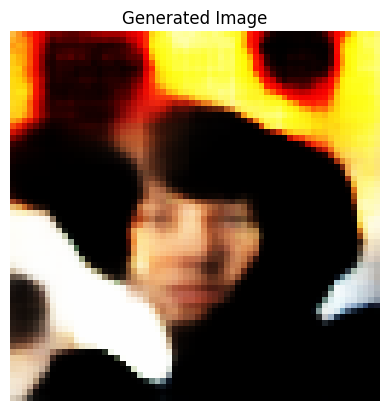

In [ ]:
# Visualize
# Generate a random sample from a normal distribution
latent_dim = 64 # specify your latent dimension

z_distribution = np.random.normal(size=(1, latent_dim))
generated_image = vae.decoder(z_distribution)

generated_image_to_show = generated_image.numpy().squeeze()

# Display the generated image
plt.imshow(generated_image_to_show)
plt.title('Generated Image')
plt.axis('off')
plt.show()

## Task 3.3 Modify sample generation with desired attributes
- VAE learns a probability distribution of possible latent representations. By conditioning the space on desired attributes we can compare output from the two latent probability spaces (with and without the desired attribute.)
- Celeb A dataset comes with a set of hand annotated features for each image
- By building a latent space conditioned on a selected feature, the desired attribute should be prominent




In [ ]:
%%html
<iframe src="https://drive.google.com/file/d/1z4OVK9yWa-4Q-Rjsok7ET6gJGiXYKi_K/preview" width="640" height="480" allow="autoplay"></iframe>



```
# This is formatted as code
```

By adding the following to your **preprocessing function**, we can use the desired attributes as label to train a model with spesific properties.
```
if mode == 'attributes':
    img = example['image']
    attri = example['attributes']
    if attri[att]:
        label = 1
    else:
        label = 0
    img = tf.image.resize(img, size=size)/255.0
    return img, label
```

In [ ]:
def preprocess_with_attributes(example, size=(img_h, img_w), mode='train', att='Smiling'):
    if mode == 'attributes':
        image = example['image']
        attrib = example['attributes']
        label = tf.cast(attrib[att], dtype=tf.float32)  # Convert boolean attribute to float (0 or 1)
        image_prep = tf.image.resize(image, size=size) / 255.0 # Resize the image and Normalize pixel values to the range [0, 1]
        return image_prep, label


    else:
        image_resized = tf.image.resize(image_normalized, size=size)
        image_normalized = image_resized / 255.0
        return image_normalized, image_normalized  # Return the same image for both input and target

# Apply preprocessing with attributes to the training set
train_att_ds = celeba_train.map(lambda x: preprocess_with_attributes(x, size=(img_h, img_w), mode='attributes', att='Smiling'))
train_att_ds = train_att_ds.batch(BATCH_SIZE)
train_att_ds = train_att_ds.take(20)



Having defined the images with and without desired attribute, can can seperate them into two subset for training.

In [ ]:
# Sorting relevant images
img_with = []
img_without = []
for images, labels in train_att_ds:
    for i in range(BATCH_SIZE):
        if labels[i]==1:
            img_with.append(images[i])
        else:
            img_without.append(images[i])
img_with, img_without = np.array(img_with), np.array(img_without)

In [ ]:
_, z_mean_with, _ = vae.encoder(img_with)
attribute_vector = tf.reduce_mean(z_mean_with, axis=0, keepdims=True)

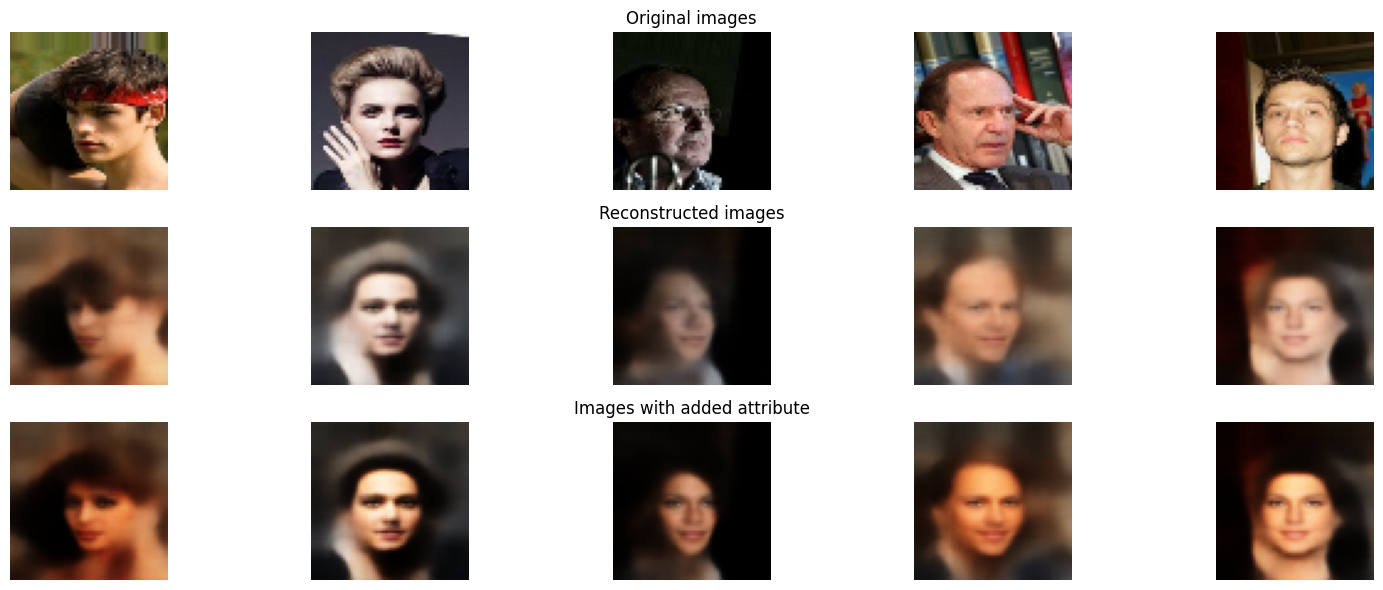

In [ ]:
# Visualizing resutls
n_examples = 5
beta = 0.5

# Original encoding
og_enc = vae.encoder(img_without)[0]

att_enc = og_enc + beta*attribute_vector

decoded_og_enc = vae.decoder(og_enc)
decoded_att_enc = vae.decoder(att_enc)

f, axs = plt.subplots(3, n_examples, figsize=(16, 6))

axs[0, n_examples // 2].set_title("Original images")
axs[1, n_examples // 2].set_title("Reconstructed images")
axs[2, n_examples // 2].set_title("Images with added attribute")


for j in range(n_examples):
    axs[0, j].imshow(img_without[j])
    axs[1, j].imshow(decoded_og_enc[j])
    axs[2, j].imshow(decoded_att_enc[j])
    for ax in axs[:, j]:
        ax.axis('off')

plt.tight_layout()

## Task 3.4 Interpolation between points in the latent space

Interpolating the latent space of a generative machine learning model involves smoothly transitioning between different points in the latent space to generate new samples.

For example, in a model trained on images of faces, interpolating in the latent space would involve finding a path between two latent vectors corresponding to two different faces. As we traverse this path, the model generates images that morph gradually from one face to the other. This process allows us to create novel samples that possess characteristics of both original data points.

Overall, latent space interpolation provides a powerful tool for generating diverse and realistic data samples, enabling the model to create entirely new outputs that blend characteristics of the training data.

In [ ]:
%%html
<iframe src="https://drive.google.com/file/d/18qEB5YoxNpDqYyHgGXo0QZpx-VHNjWEb/preview" width="640" height="480" allow="autoplay"></iframe>

Run the following code

In [ ]:
# Uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=5):
    ratios = np.linspace(0, 1, num=n_steps)
    # linear interpolate vectors
    vectors = list()
    for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2
        vectors.append(v)
    return np.asarray(vectors)

In [ ]:
def create_interpolated_sampels():
    num_steps = 8
    step_size = 1.0 / num_steps

    sample_a = None
    sample_b = None

    # retriving data that corresponded to the class indices
    for i, data in enumerate(train_att_ds):
        img, label = data
        sample_a = img[i] if label[i] == 1 else None
        if sample_a != None:
          break

    for i, data in enumerate(train_att_ds):
        img, label = data
        sample_b = img[i] if label[i] == 0 else None
        if sample_b != None:
            break

    sample_a = tf.reshape(sample_a, [1,img_h,img_w,3])
    sample_b = tf.reshape(sample_b, [1,img_h,img_w,3])

    # encoding both images to get sampled z values of both classes
    z_a = np.array(encoder_mod(sample_a)[0])#.reshape(1, -1)
    z_b = np.array(encoder_mod(sample_b)[0])#.reshape(1, -1)


    # interpolation
    diff = z_b - z_a
    steps = np.array(tf.range(0.0, 1.0+step_size, step_size))#.reshape(-1, 1)
    zs = []
    for i in steps:
        zs.append(z_a + (i * diff))
    zs = np.array(zs).reshape(-1, len(sample_a), 64)

    out_imgs = []
    for j in range(len(zs)):
        out_imgs.append(decoder_mod(zs[j]))

    return out_imgs

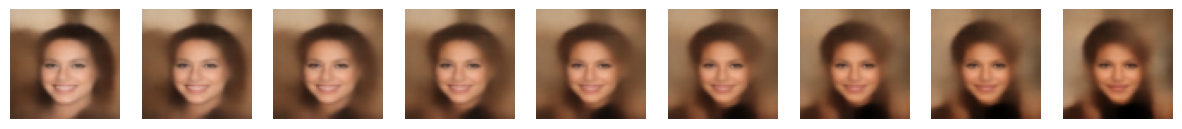

In [ ]:
interpol_img = create_interpolated_sampels()
fig, ax = plt.subplots(1, len(interpol_img), figsize=(15,15))
for img in range(len(interpol_img)):
    ax[img].imshow(interpol_img[img][0])
    ax[img].axis('off')



---



# Task 4: Bonus
Use your trained network to manipulate a selfi of yourself by altering an attribute (i.e. smile,  hair style, eyes, etc.)

In [ ]:
# Load image
test_img = PIL.Image.open('/content/Haris.JPG')

# Resize to fit model
test_img = test_img.resize((img_h, img_w), PIL.Image.ANTIALIAS)

# Convert to machine-readable input
test_img = np.expand_dims(np.array(test_img) / 255, 0)

# Encode the image
z_mean = vae.encoder.predict(test_img)[0]

# Manipulate the encoded attribute
attribute_vector = np.array([1])
z_manipulated = z_mean + 3 * attribute_vector

# Reconstruct images using the decoder, not the encoder
reconstructed_original = vae.decoder.predict(z_mean)
reconstructed_manipulated = vae.decoder.predict(z_manipulated)


1/1 [==============================] - 0s 26ms/step


<ipython-input-82-e5b3ba3781d3>:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  test_img = test_img.resize((img_h, img_w), PIL.Image.ANTIALIAS)


1/1 [==============================] - 0s 76ms/step


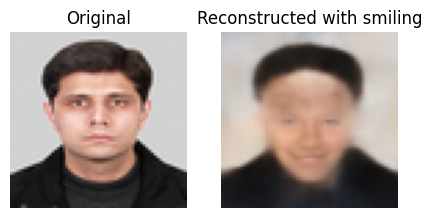

In [ ]:
# Plot images
fig, ax = plt.subplots(1, 2, figsize=(5, 5))

# Original image
ax[0].imshow(test_img[0])
ax[0].axis('off')
ax[0].set_title('Original')

# Reconstructed from original space
ax[1].imshow(reconstructed_original[0])
ax[1].axis('off')
ax[1].set_title('Reconstructed with smiling')

plt.show()